# Lab Assignment Two: Exploring Image Data

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Business Understanding 

This data was collected through Bing images of various car types and uploaded on Kaggle. There are 4,165 images and 7 classes of cars, and all of them are larger than the 20 x 20 pixel size requirement. It is sepearated into two folders: testing and training; with subfolders for each car category. Although there is no information on why the dataset was collected, it is likely for training and evaluating machine learning models for image classification tasks related to automobiles.

Classifying vehicles is of great important in multiple facets of industry, the main one being transport and logistic management companies/systems (also known as Intelligent Transport System, or ITS), for traffic accident investigation, traffic flow monitoring, and autonomous driving, as indicated by this recent review (https://www.mdpi.com/1424-8220/23/10/4832). Typically the method that is use for predicting the features/type of car from an image is through deep learning, such as the convolutional neural networt (CNNs) for vehicle classification, and have seen some success with low-resolution images (https://www.mdpi.com/1424-8220/22/13/4740). Before one can use such highly sophiscated methods, it is imperative to prepare the data and reduce the dimensionality of the data through feature extraction. In this way, we can improve the efficiency of the classification and reduce the computational resources required for the predictive task. 

Some real life applications, as mentioned briefly with the ITS, we can utilze the prediction task to identify the automobile type, and then using information about the types of vehicles present in different areas, traffic management authorities can make informed decisions about traffic flow optimization, lane management, and infrastructure planning. 

### Measures of Success

In the application of traffic planning/monitoring with classifying a variety of automobiles on the road, there are a few ways to measure the success of the predictive model. Prediction and accuracy are fundamental, for the traffic managment system to rely on the prediction to make informed decisions on traffic flow optimization. Another important factor for success is having the classification in real-time, with no delay or latency. However, an often missed factor that would be paramount in the success of the machine learning model would be robustness. 

For example, let us take a random numpy array, with a training set of 800 synthetic images and 200 testing images, 32 x 32 pixels with 3 color channels (RGB):

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess the dataset
# For demonstration, we'll generate synthetic data
X_train = np.random.rand(800, 32, 32, 3)
y_train = np.random.randint(0, 7, size=800)
X_test = np.random.rand(200, 32, 32, 3)
y_test = np.random.randint(0, 7, size=200)

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

Next, we can just arbitrarily create and train a convolutional neural network (CNN) model for image classification tasks, with a specific architecture comprising convolutional and fully connected layers, compiled with the Adam optimizer and evaluated using sparse categorical cross-entropy loss and accuracy metrics.

In [34]:
# Define a function to train the classification model
def train_model(X_train, y_train):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(7, activation='softmax')  # Assuming 7 output classes
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)  

    return model

Now, we will define a function 'evaluate_robustness' to assess the robustness of a trained classification model. Specifically, it tests the model's robustness using data augmentation, where the test data is augmented with variations in rotation, width, height, and zoom, and evaluates the model's accuracy on the augmented test data.

In [35]:
# Define a function to perform robustness testing
def evaluate_robustness(model, X_test, y_test):
    # Evaluate accuracy on original test data
    accuracy_original = model.evaluate(X_test, y_test, verbose=0)[1]
    print("Accuracy on original test data:", accuracy_original)

    # Data augmentation for robustness testing
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    augmented_iterator = datagen.flow(X_test, y_test, shuffle=False)
    X_augmented, y_augmented = augmented_iterator.next()

    accuracy_augmented = model.evaluate(X_augmented, y_augmented, verbose=0)[1]
    print("Accuracy on augmented test data:", accuracy_augmented)

    # Adversarial attack for robustness testing
    epsilon = 0.1  # Perturbation strength
    X_adversarial = X_test + epsilon * np.sign(np.random.randn(*X_test.shape))
    X_adversarial = np.clip(X_adversarial, 0, 1) 

    # Evaluate accuracy on adversarial test data
    accuracy_adversarial = model.evaluate(X_adversarial, y_test, verbose=0)[1]
    print("Accuracy on adversarial test data:", accuracy_adversarial)

model = train_model(X_train, y_train)

# Evaluate robustness
evaluate_robustness(model, X_test, y_test)

NameError: name 'models' is not defined

In this randomly generated data, we can see that these accuracies provide insights into how the model generalizes and performs under various conditions. In this case, the model's performance is relatively low across all datasets, indicating potential issues with generalization and robustness. Further analysis and improvements may be necessary to enhance the model's performance and robustness.

Dataset source: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset

### 2. Data Preparation
#### 2.1. Read Images

In [7]:
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.decomposition import PCA
from skimage import metrics
from sklearn.preprocessing import LabelEncoder, minmax_scale

In [8]:
images = defaultdict(list)
labels = defaultdict(list)
uniformed_size = (224,224)

# load and resize images
for image_path in Path('data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)),uniformed_size)
    images[train_test].append(img)
    labels[train_test].append(class_name)

# concatenate to two ndarrays
train_imgs = np.concatenate([images['train']])
test_imgs = np.concatenate([images['test']])

# encode string lables to numeric labels
encoder = LabelEncoder()
encoder.fit(labels['test'])
test_labels = encoder.transform(labels['test'])
train_labels = encoder.transform(labels['train'])

print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 224, 224, 3), Test: (813, 224, 224, 3)


#### 2.2. Linearize

In [9]:
train_imgs = train_imgs.reshape((len(train_imgs), -1))
test_imgs = test_imgs.reshape((len(test_imgs), -1))
print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 150528), Test: (813, 150528)


#### 2.3. Visualization

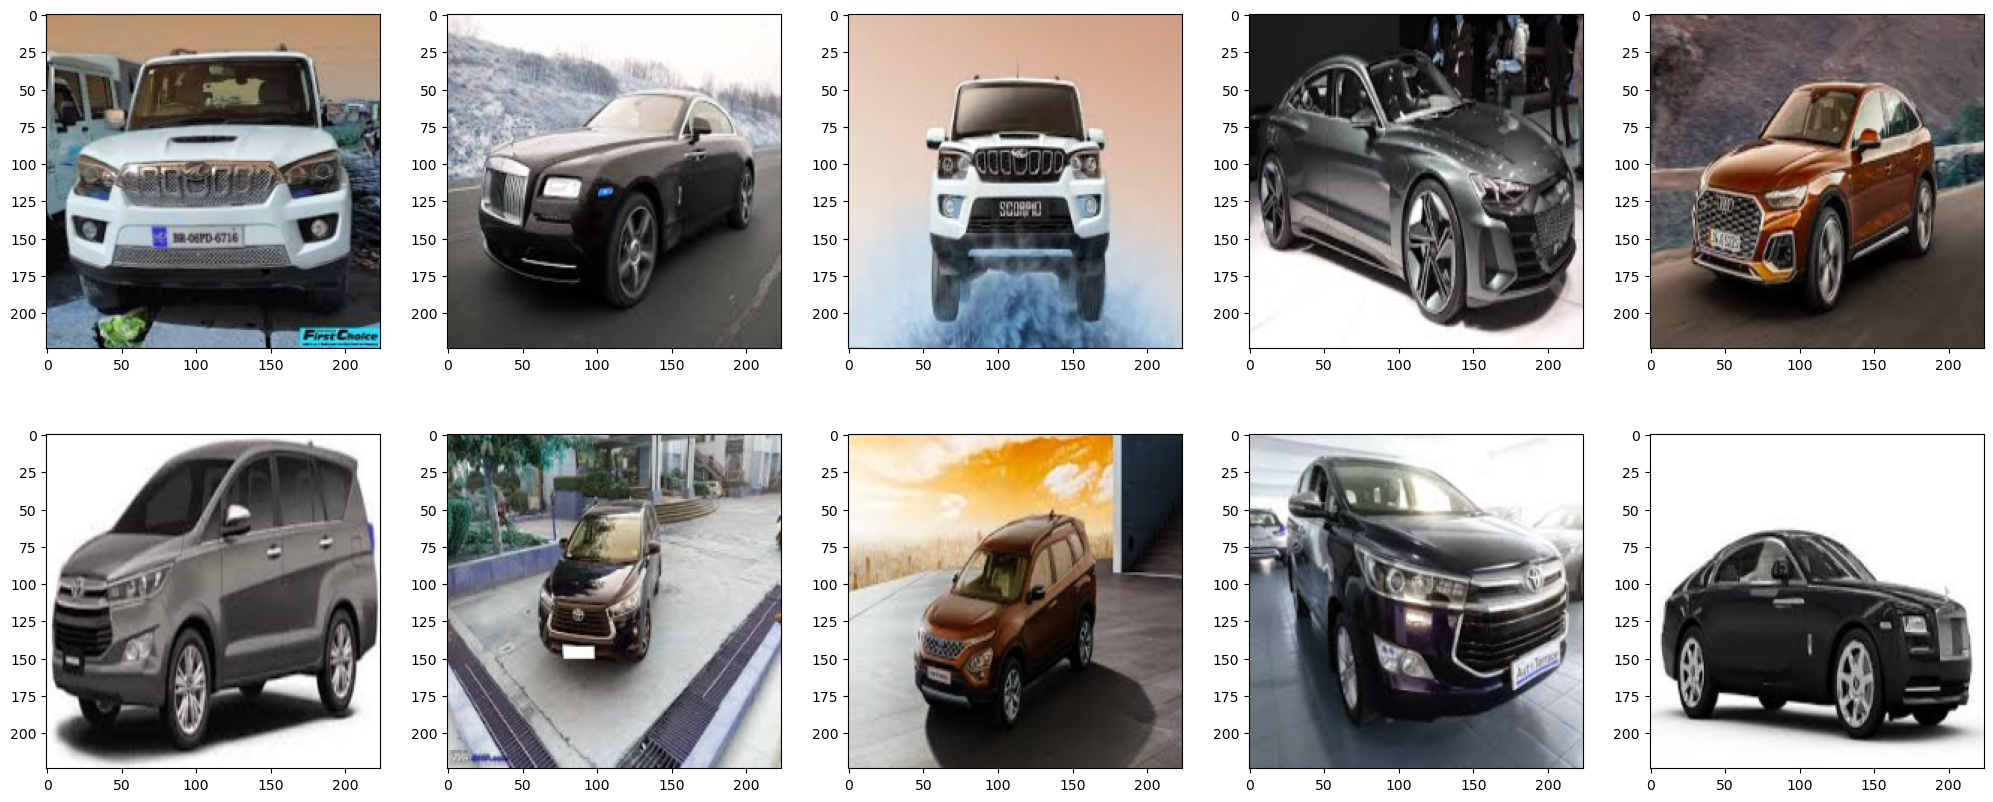

In [11]:
plt.figure(figsize=(25,10))
for i, r_idx in enumerate(np.random.randint(0, len(images['train']), 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images['train'][r_idx])

### 3. Data Reduction

#### 3.1 PCA

In [12]:
def run_PCA_analysis(data, n_components=150, required_component_ratio = 0.8, randomized = False):
    # PCA
    pca = PCA(n_components, svd_solver="randomized" if randomized else "auto")
    pca_data = pca.fit_transform(data)
    
    # Analyze how many components are required to adequately represent the image data.
    accumulated_ratio = np.cumsum(pca.explained_variance_ratio_)
    ratio_idx = np.argmax(accumulated_ratio >= required_component_ratio)

    # ploting
    plt.figure(figsize=(20,5))
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
    plt.xticks(range(1, n_components+1, 3), rotation=70)
    plt.yticks(np.arange(0, 0.30, 0.01), [f"{x*100:.1f}%" for x in np.arange(0, 0.30, 0.01)])
    plt.xlim(0, n_components+1)

    ax = plt.twinx()
    ax.set_yticks(np.arange(0, 1.01, 0.05), [f"{x*100:.1f}%" for x in np.arange(0, 1.01, 0.05)])
    ax.set_ylim(0,1)
    ax.plot(range(1, n_components+1), accumulated_ratio, color='orange')
    ax.axvline(x=ratio_idx, color='red', linestyle='--')
    ax.axhline(y=required_component_ratio, color='red', linestyle='--')

    plt.title("explained variance of each components")
    return pca, pca_data

Wall time: 13.4 s


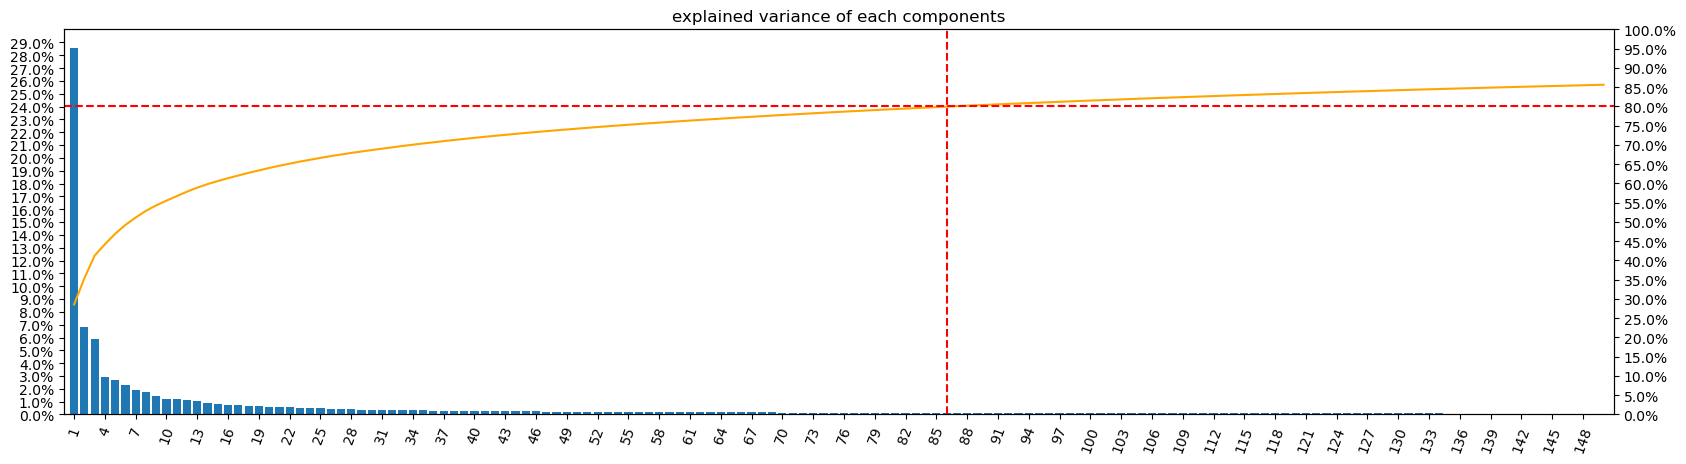

In [13]:
n_components = 150
required_component_ratio = 0.8
original_images = test_imgs
%time pca, pca_data = run_PCA_analysis(original_images, n_components, required_component_ratio);

The analysis above used PCA to deduct the image demension from 150528 to 150. And then the number of components that are required to adequately represent the image data is determined by a 0.8 threshold. As the red dotted lines shown above, it is clear that the first 112 principal components can adequately represent the images with given threshold.

#### 3.2 Random PCA

Wall time: 13.2 s


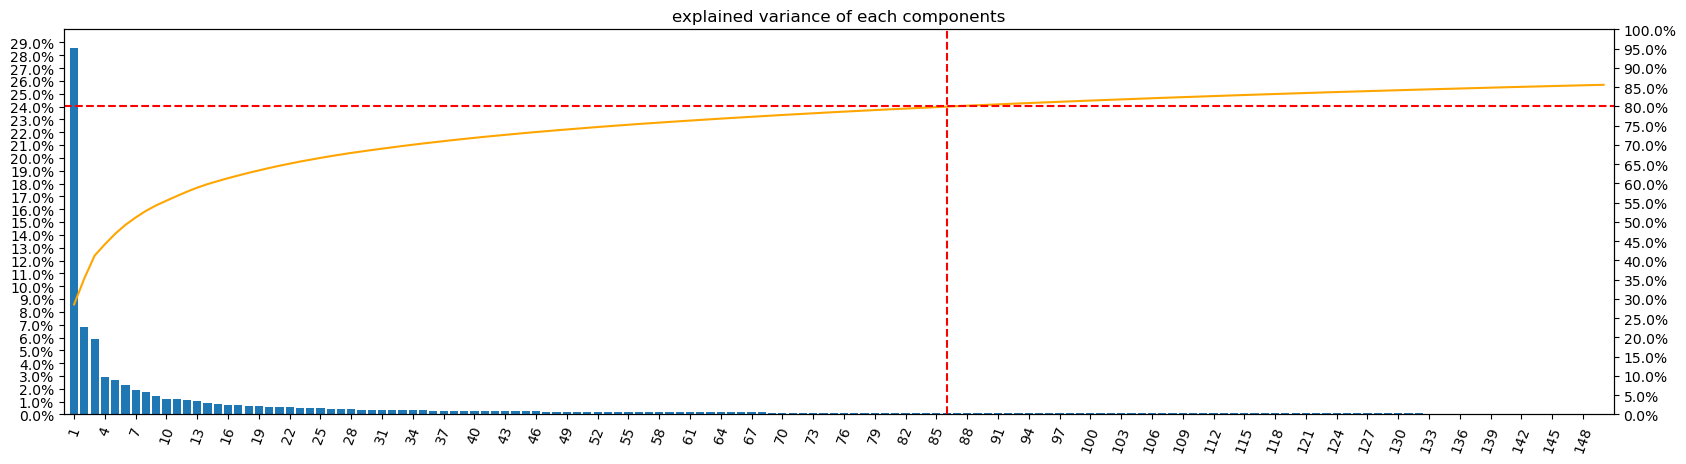

In [14]:
%time random_pca, random_pca_data = run_PCA_analysis(original_images, n_components, required_component_ratio, randomized = True);

The randomized PCA produced similar result to PCA. The number of components that are required to adequately represent the image data is 112.

#### 3.3 Comparison between PCA and Randomized PCA

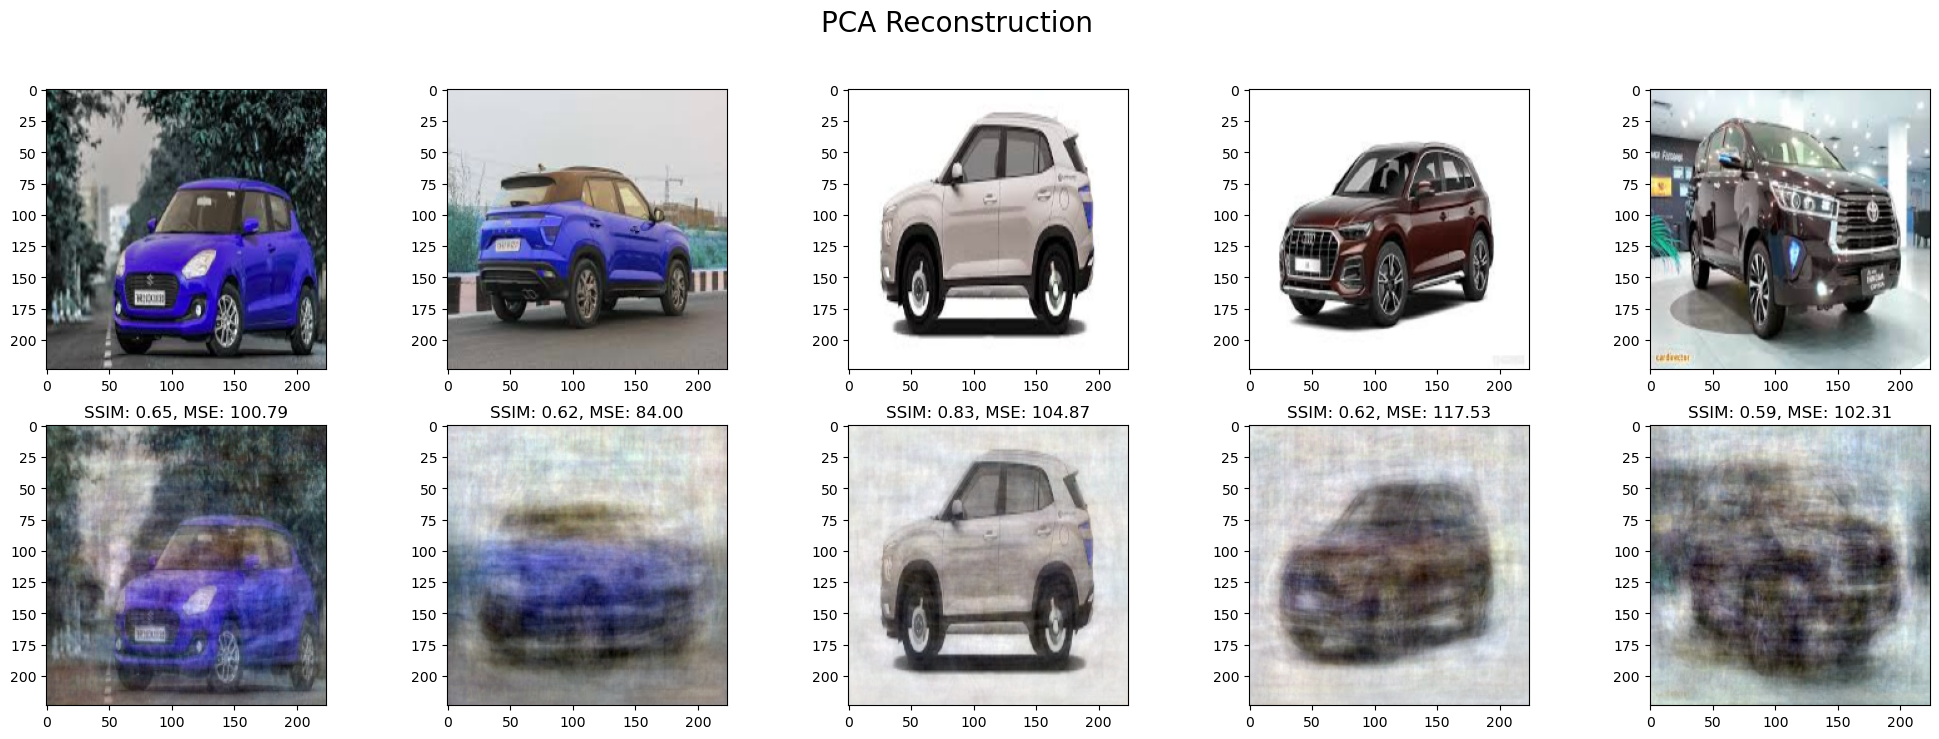

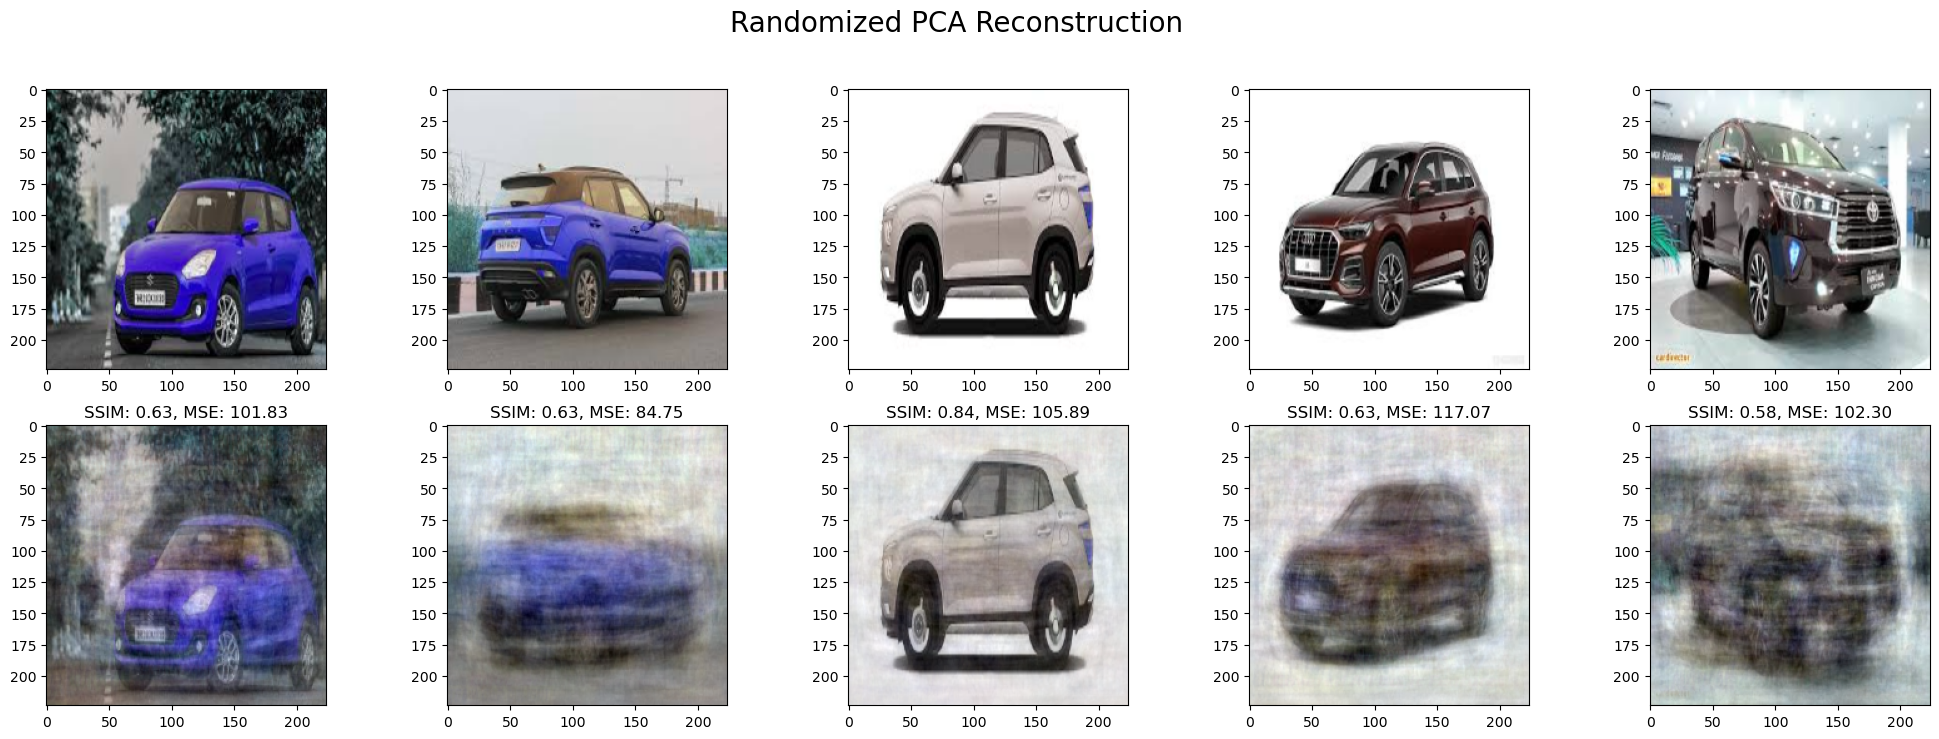

In [15]:
def reconstruct_image(trans_obj, low_rep):
    # reconstruct images from deducted data
    rec_image = trans_obj.inverse_transform(low_rep)
    shp = rec_image.shape
    rec_image = minmax_scale(rec_image.ravel(), (0,255)).astype(np.uint8)
    return rec_image.reshape(shp)

def reconstruct(randomized_PCA=False):
    # reconstruct few images and visualize
    plt.figure(figsize=(25,8))
    for i, r_idx in enumerate(np.random.randint(0, len(original_images), 5)):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(original_images[r_idx].reshape((*uniformed_size, -1)))
        low_rep = random_pca_data[r_idx:r_idx+1] if randomized_PCA else pca_data[r_idx:r_idx+1]
        rec_image = reconstruct_image(random_pca if randomized_PCA else pca, low_rep)
        ax = plt.subplot(2,5,i+6)
        ax.imshow(rec_image.reshape((*uniformed_size, -1)))
        
        # calculate MSE and SSIM
        SSIM = metrics.structural_similarity(original_images[r_idx], rec_image.ravel())
        MSE = np.mean((original_images[r_idx] - rec_image) ** 2)
        ax.set_title(f"SSIM: {SSIM:.2f}, MSE: {MSE:.2f}")

    plt.suptitle(('Randomized ' if randomized_PCA else '') +'PCA Reconstruction', fontsize = 20)

# make sure the comparison use same set of images
seed = np.random.randint(0, 9999) 
np.random.seed(seed)

reconstruct(randomized_PCA = False)
np.random.seed(seed)
reconstruct(randomized_PCA = True)

In [16]:
def calc_metrics(rec_images):
    # calculate SSIM and MSE metrics
    SSIMs, MSEs = [], []
    for i in range(original_images.shape[0]):
        MSE = np.mean((original_images[i] - rec_images[i]) ** 2)
        MSEs.append(MSE)
        SSIM = metrics.structural_similarity(original_images[i], rec_images[i])
        SSIMs.append(SSIM)
    return SSIMs, MSEs

# reconstruct all images
rec_images = reconstruct_image(pca, pca_data)
rec_images_random = reconstruct_image(random_pca, random_pca_data)

# calculate SSIM and MSE
SSIMs_pca, MSEs_pca = calc_metrics(rec_images)
SSIMs_random_pca, MSEs_random_pca = calc_metrics(rec_images_random)

Text(0.5, 0, 'MSE')

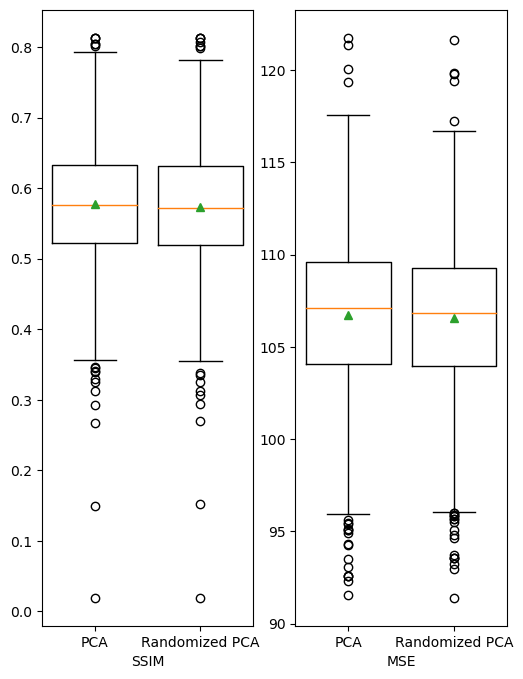

In [17]:
# Visualize SSIM and MSE
plt.figure(figsize=(6,8))
ax = plt.subplot(1,2,1)
ax.boxplot([SSIMs_pca,SSIMs_random_pca], showmeans=True, widths = 0.8)
ax.set_xticklabels(['PCA', 'Randomized PCA'])
ax.set_xlabel('SSIM')
#ax.axhline(np.mean(SSIMs_pca))
ax = plt.subplot(1,2,2)
ax.boxplot([MSEs_pca, MSEs_random_pca], showmeans=True, widths = 0.8)
#ax.axhline(np.mean(MSEs_pca))
ax.set_xticklabels(['PCA', 'Randomized PCA'])
ax.set_xlabel('MSE')

From the analysis above, the Randomized PCA have a slightly better average representation (green triangles) compared to PCA. The Randomized PCA presents a higher similarity on reconstructed images and lower MSE than PCA. Therefore, Randomized PCA is better at representing the images with fewer components. I prefer Randomized PCA. It is more efficient on large datasets.

#### 3.4 Feature extraction 
Start by calculating gradients

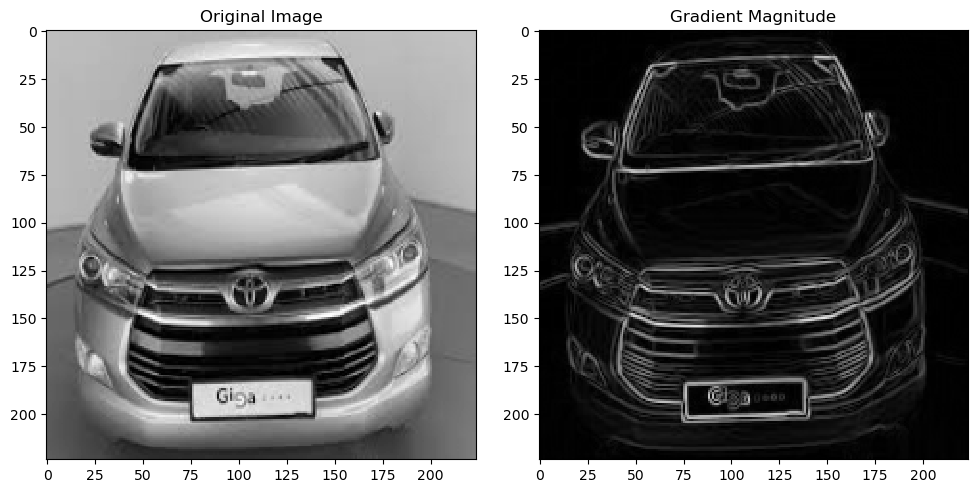

In [19]:

from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

import warnings
warnings.filterwarnings("ignore")


h, w = uniformed_size  # As per the initial setup

plt.figure(figsize=(10, 5))

# Select a random image from the training dataset
idx_to_reconstruct = np.random.randint(len(train_imgs))
img = train_imgs[idx_to_reconstruct].reshape((h, w, 3))

plt.subplot(1, 2, 1)

# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img = rgb2gray(img)
imshow(gray_img, cmap='gray')  # Display the grayscale image
plt.title('Original Image')
plt.grid(False)


plt.subplot(1, 2, 2)
# Calculate and show the gradient magnitude
gradient_mag = np.sqrt(sobel_v(gray_img)**2 + sobel_h(gray_img)**2)
imshow(gradient_mag, cmap='gray')
plt.title('Gradient Magnitude')
plt.grid(False)

plt.show()

Implement Gabor filter feature extraction

In [20]:
from skimage.filters import gabor
from skimage import img_as_float, transform


def extract_gabor_features(images, resize_dim=(100, 100), frequency=0.6):
    gabor_features = []
    for img in images:
        # Resize image to reduce computation time
        small_image = transform.resize(img, resize_dim, anti_aliasing=True)
        # Convert to grayscale
        gray_img = rgb2gray(small_image)
        # Appli Gabor filter
        real, image = gabor(gray_img, frequency=frequency)
        # Combine the real and imaginary parts or use just one, depending on the application
        # Flattening the features
        gabor_features.append(np.stack([real, image], axis=-1).flatten())

    return np.array(gabor_features)


# Extract Gabor features for training and testing sets
train_gabor_features = extract_gabor_features(images['train'])
test_gabor_features = extract_gabor_features(images['test'])

Apply for Daisy feature extraction

In [21]:
from skimage.feature import daisy
from skimage import img_as_float, transform


def extract_daisy_features(images, resize_dim=(100, 100), step=100, radius=16, rings=2, histograms=6, orientations=8):
    daisy_features = []
    for image in images:
        # Resize image to reduce computation time
        small_image = transform.resize(image, resize_dim, anti_aliasing=True)
        # Convert image to grayscale as DAISY works on single channel images
        gray_image = rgb2gray(small_image)
        # Convert image to float type required by DAISY function
        image_float = img_as_float(gray_image)
        # Extract DAISY features from the image
        descs = daisy(image_float, step=step, radius=radius, rings=rings,
                      histograms=histograms, orientations=orientations, visualize=False)
        # Flatten the DAISY descriptors to create a single feature vector per image
        daisy_features.append(descs.flatten())
    return np.array(daisy_features)


train_daisy_features = extract_daisy_features(images['train'])
test_daisy_features = extract_daisy_features(images['test'])

#### 3.5 Analyze Various Feature Extraction Methods
- Visualize the pairwise differences among all extracted features, ordered by class. Find the cloest image based on feature extraction method.
- Build a nearest neighbor classifier to evaluate actual classification performance per each method

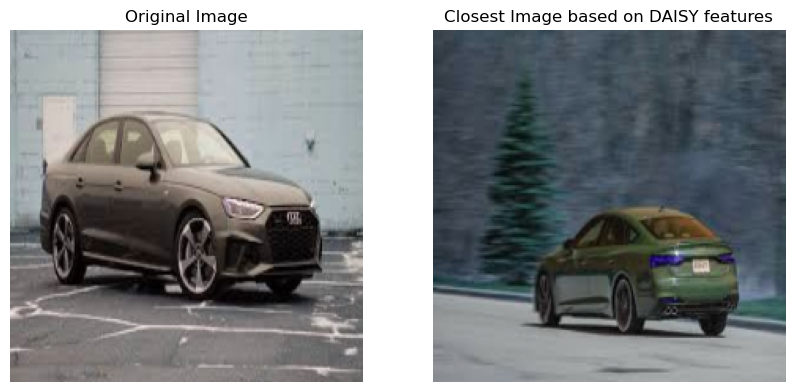

In [22]:
from sklearn.metrics.pairwise import pairwise_distances


def imshow(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Function to find and show closest images based on DAISY features


def show_closest_images(index, dist_matrix, images):
    distances = dist_matrix[index].copy()
    # Set the distance to itself to infinity to avoid self-selection
    distances[index] = np.inf
    closest_index = np.argmin(distances)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(images[index], "Original Image")
    plt.subplot(1, 2, 2)
    imshow(images[closest_index], "Closest Image based on DAISY features")
    plt.show()


# Show the closest image to the first image in the training set
# First, calculate the pairwise distances between DAISY features of training images
dist_matrix = pairwise_distances(train_daisy_features)


# Then, display the original and closest image in the training set
show_closest_images(2, dist_matrix, images['train'])

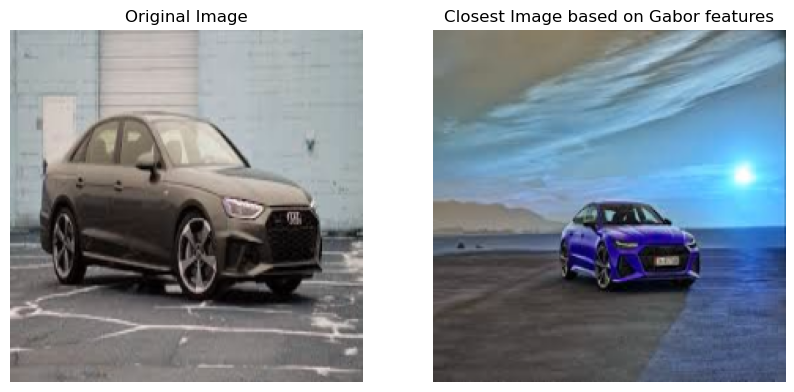

In [23]:
# Function to find and show closest images based on Gabor features
def show_closest_images(index, dist_matrix, images):
    distances = dist_matrix[index].copy()
    distances[index] = np.inf
    closest_index = np.argmin(distances)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(images[index], "Original Image")
    plt.subplot(1, 2, 2)
    imshow(images[closest_index], "Closest Image based on Gabor features")
    plt.show()


# Calculate the pairwise distances between DAISY features of training images
train_dist_matrix = pairwise_distances(train_gabor_features)


# Then, display the original and closest image in the training set
show_closest_images(2, train_dist_matrix, images['train'])

#### Nearest Neighbors Classification  with each Feature Space

In [24]:
# KNN classifier for GRADIENT features
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Function to extract gradient magnitude features from a single image


def extract_gradient_features(img, uniformed_size=(224, 224)):
    # Reshape and convert the image to grayscale
    img = img.reshape((*uniformed_size, 3))
    gray_img = rgb2gray(img)
    # Calculate gradient magnitudes
    gradient_mag = np.sqrt(sobel_v(gray_img)**2 + sobel_h(gray_img)**2)
    # Flatten the gradient magnitude matrix to create a feature vector
    feature_vector = gradient_mag.flatten()
    return feature_vector


# Extract features for all images
train_features = np.array([extract_gradient_features(img)
                          for img in images['train']])
test_features = np.array([extract_gradient_features(img)
                         for img in images['test']])

# Split the training data into a smaller train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on the validation set
y_pred = knn.predict(X_val)
# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Confusion Matrix:
[[63  0  0 45  5 68  4]
 [18  3  0  6  0 20  1]
 [13  0  6 11  0 29  5]
 [18  0  0 17  1 24  1]
 [10  0  0 19 17 32  2]
 [10  0  0 14  4 58  1]
 [19  0  0 23  9 63 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.34      0.38       185
           1       1.00      0.06      0.12        48
           2       1.00      0.09      0.17        64
           3       0.13      0.28      0.17        61
           4       0.47      0.21      0.29        80
           5       0.20      0.67      0.30        87
           6       0.70      0.22      0.33       146

    accuracy                           0.29       671
   macro avg       0.56      0.27      0.25       671
weighted avg       0.53      0.29      0.29       671



                  precision    recall  f1-score   support

            Audi       0.35      0.70      0.46       199
   Hyundai Creta       0.93      0.60      0.73        67
Mahindra Scorpio       1.00      0.25      0.40        75
     Rolls Royce       0.17      0.20      0.18        74
           Swift       0.82      0.46      0.59       102
     Tata Safari       0.66      0.70      0.68       106
   Toyota Innova       0.83      0.38      0.53       190

        accuracy                           0.50       813
       macro avg       0.68      0.47      0.51       813
    weighted avg       0.65      0.50      0.51       813



<AxesSubplot:>

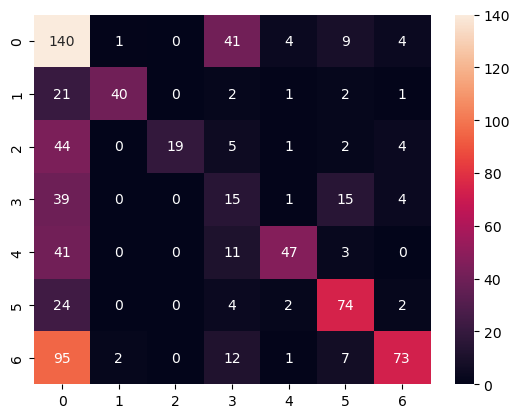

In [25]:
# KKN classifier for gabor features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Train a Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_gabor_features, labels['train'])

# Predict on the test set
predicted_labels = knn.predict(test_gabor_features)

# Classification report
print(classification_report(labels['test'], predicted_labels))

# Confusion matrix
cm = confusion_matrix(labels['test'], predicted_labels)
sns.heatmap(cm, annot=True, fmt="d")

                  precision    recall  f1-score   support

            Audi       0.49      0.44      0.47       199
   Hyundai Creta       0.48      0.66      0.55        67
Mahindra Scorpio       0.45      0.36      0.40        75
     Rolls Royce       0.22      0.19      0.20        74
           Swift       0.54      0.51      0.52       102
     Tata Safari       0.67      0.70      0.69       106
   Toyota Innova       0.53      0.59      0.56       190

        accuracy                           0.51       813
       macro avg       0.48      0.49      0.48       813
    weighted avg       0.50      0.51      0.50       813



<AxesSubplot:>

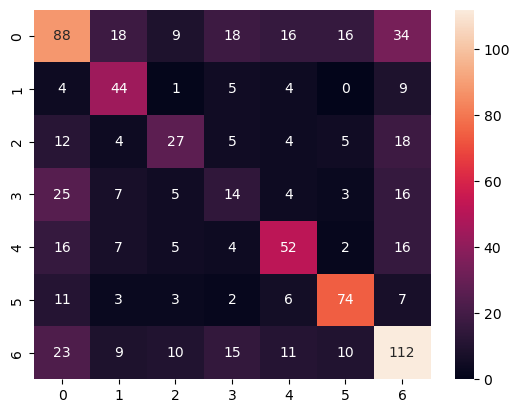

In [26]:
# KKN classifier for daisy features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Train a Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_daisy_features, labels['train'])

# Predict on the test set
predicted_labels = knn.predict(test_daisy_features)

# Classification report
print(classification_report(labels['test'], predicted_labels))

# Confusion matrix
cm = confusion_matrix(labels['test'], predicted_labels)
sns.heatmap(cm, annot=True, fmt="d")

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


knn_dsy = KNeighborsClassifier(n_neighbors=1)
knn_gabor = KNeighborsClassifier(n_neighbors=1)

knn_dsy.fit(train_daisy_features, train_labels)
acc_dsy = accuracy_score(knn_dsy.predict(test_daisy_features), test_labels)

knn_gabor.fit(train_gabor_features, train_labels)
acc_gabor = accuracy_score(knn_gabor.predict(test_gabor_features), test_labels)

# report accuracy
print(f"Daisy Accuracy:{100*acc_dsy:.2f}%, Gabor accuracy:{100*acc_gabor:.2f}")

Daisy Accuracy:50.55%, Gabor accuracy:50.18


Based on the provided output, we can analyze the performance of the three feature extraction techniques: ordered gradients, Gabor features, and DAISY features, and assess their promise for the prediction task.

Data Reduction Analysis 
1.	Gabor Features:
- The classification report shows the precision and recall values are good for most classes, especially for 'Hyundai Creta' and 'Tata Safari'. However, there are still issues with certain classes like 'Mahindra Scorpio' with high precision but very low recall.
The overall accuracy has increased to 50%, significantly improving over the ordered gradients method.
2.	DAISY Features:
- The performance is similar to the Gabor features with an overall accuracy of 51%, which is a slight improvement over the Gabor features. Precision and recall values across different classes are more balanced compared to Gabor features, indicating a slightly better and more consistent classification performance.
- The DAISY feature extraction shows promise as it maintains a balance between precision and recall better than the other two methods.
Nearest neighbor classifier performance using DAISY and Gabor features (with accuracies around 50%) suggests these methods provide features that are somewhat useful for classification, but there might be room for improvement or a need for parameter tuning.

Visual Analysis:
1.	Gradient Features:
- The image appears clear with distinguishable details of the car and the surroundings.
- This image represents the gradient magnitude of the original image, highlighting the edges and contours of the car and its environment, emphasizing areas of significant intensity changes. 
- In gradient magnitude images, bright areas represent high changes in intensity which typically correspond to edges in the image. This is visible around the contours of the car, the license plate, the design elements on the car's body, and the boundaries between different elements in the background.
- This is crucial in various computer vision tasks such as edge detection, object recognition, and feature extraction, as edges often carry important information about the shape and structure of objects. The gradient magnitude feature extraction seems effective in highlighting the structural details of the car, which could be beneficial for tasks requiring edge or shape detection.

2.	DAISY Features:
- Original Image: Shows a car in a city environment.
- Closest Image based on DAISY features: Displays a car that, while in a different environment, appears to have a similar body shape and style as the original. The angle and positioning also seem quite matched, which might have contributed to it being recognized as the closest image. This indicates that DAISY features are likely to capture and compare geometric patterns and spatial characteristics of the vehicles.
3.	Gabor Features:
- Original Image: The same original image as used in the DAISY comparison.
- Closest Image based on Gabor features: Presents a different sedan under different environmental conditions but with a somewhat similar body style. The color and setting are markedly different, yet the Gabor features have identified a vehicle with similar textural and edge characteristics. This suggests that while Gabor features might not directly focus on the exact shape, they capture the texture and pattern aspects effectively, leading to a match based on these attributes rather than on color or exact geometry such as environmental background.	 



### 4. Exceptional Work  - Key Point Matching Using DAISY Features
Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive. Does it perform better than not using key point matching? 

For key point matching, we will use DAISY features but focus on matching individual key points between images instead of comparing whole-image descriptors.

In [28]:

from skimage.feature import match_descriptors, daisy
from skimage import img_as_float, transform, color


def extract_daisy_features_and_keypoints(images, resize_dim=(100, 100), step=180, radius=15,
                                         rings=2, histograms=6, orientations=8):
    daisy_descriptors = []
    for idx, image in enumerate(images):
        print(f'{idx}', end='\r')
        small_image = image.reshape((*resize_dim, 3))
        gray_image = color.rgb2gray(small_image)
        # Extract DAISY features from the image, along with their keypoints
        descs = daisy(gray_image, step=step, radius=radius, rings=rings,
                      histograms=histograms, orientations=orientations)

        # Store descriptors and keypoints
        daisy_descriptors.append(descs)
        if idx == 100:
            break

    return np.array(daisy_descriptors)

# Feature extraction
test_descriptors = extract_daisy_features_and_keypoints(images['test'], (224, 224), 25, 10)

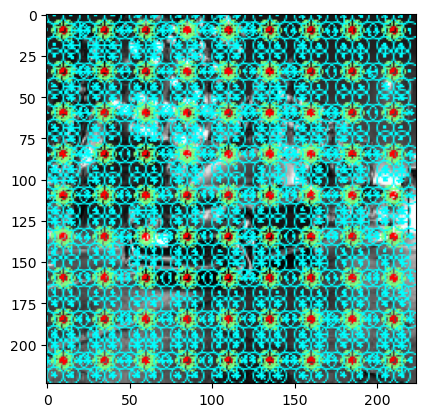

In [29]:
resize_dim = (224, 224)
small_image = images['test'][0].reshape((*resize_dim, 3))
# Convert image to grayscale as DAISY works on single channel images
gray_image = color.rgb2gray(small_image)
# Extract DAISY features from the image, along with their keypoints
descs, descs_img = daisy(gray_image, step=25, radius=10,
                         rings=2, histograms=6, orientations=8, visualize=True)
plt.imshow(descs_img)

In [30]:
# Match each pair of descriptors, find pairs have most matched keypoints
cache = {}
image_matches = []
for i in range(test_descriptors.shape[0]):
    max_matched_keypoints = -1
    max_matched_idx = -1
    for j in range(i+1, test_descriptors.shape[0]):
        if (j, i) in cache:
            num_matched = cache[(j, i)]
        else:
            test_descriptor1 = test_descriptors[i]
            test_descriptor2 = test_descriptors[j]

            test_descriptor1 = test_descriptor1.reshape(
                (-1, test_descriptor1.shape[-1]))
            test_descriptor2 = test_descriptor2.reshape(
                (-1, test_descriptor2.shape[-1]))
            matches = match_descriptors(test_descriptor1, test_descriptor2)
            num_matched = matches.shape[0]  # keypoints, 2

        if num_matched > max_matched_keypoints:
            max_matched_idx = j
            max_matched_keypoints = matches.shape[0]

        cache[(i, j)] = num_matched

    image_matches.append((i, max_matched_idx, max_matched_keypoints))

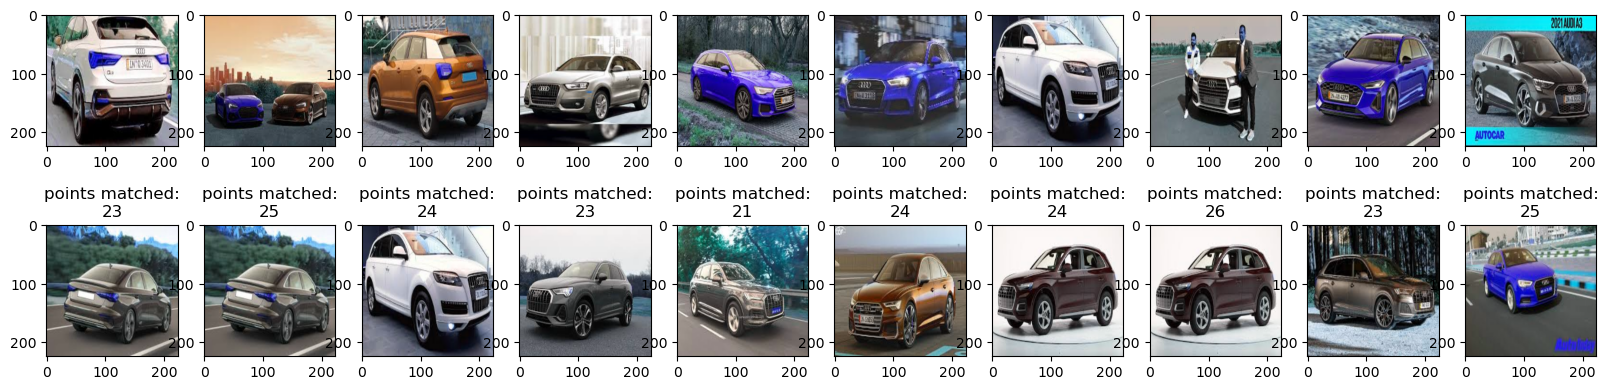

In [31]:
# visualize some pairs
import random
idx = 1
plt.figure(figsize=(20, 5))
for i, j, max_match in random.choices(image_matches, k=10):
    plt.subplot(2, 10, idx)
    plt.imshow(images['test'][i])
    plt.subplot(2, 10, idx+10)
    plt.imshow(images['test'][j])
    plt.title(f"points matched:\n{max_match}")
    idx += 1

The provided image displays pairs of cars with the number of keypoints matched between each pair using DAISY feature extraction and keypoint matching. The numbers of matched points vary between the pairs, indicating differences in similarity or feature correspondence between the images.

From the plot, we can observe:
 - The number of matched points varies significantly across different image pairs. This variation suggests that the DAISY keypoint matching method can discriminate between different levels of similarity among the images.
 - High numbers of matched points suggest a strong similarity between the images in terms of their key features. This could be due to similarities in car models, angles of photography, or specific features like headlights, grilles, and body shapes that DAISY features effectively capture.
 - Lower numbers of matched points suggest that while there are some similarities between the images, there are also significant differences, which could be due to various factors like car model differences, changes in viewpoint, or different image backgrounds.
 
The effectiveness of keypoint matching using DAISY can be further evaluated by comparing these results against a baseline ([2310.08530.pdf (arxiv.org](https://arxiv.org/pdf/2310.08530.pdf)), such as the total number of possible matches, the performance of other feature extraction methods, or the results of using the total DAISY vector without keypoint matching. However, the actual effectiveness would depend on the specific application, such as whether the task is to identify the same model of cars, differentiate between different models, or identify cars under various conditions.

If the objective is to identify or match specific car models under varying conditions, a higher number of keypoints matched could indicate better performance. Conversely, if the objective is to differentiate between different car models, you would expect lower numbers of matched keypoints for different models and higher numbers for the same models.


References:

- Kaggle. Stroke Prediction Dataset. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download (Accessed 2-04-2024)

- Center for Disease Control and Prevention. Stroke Facts. https://www.cdc.gov/stroke/facts.htm (Accessed 02-05-2024)

- Stroke Awareness Foundation. Stroke Risk Factors. https://www.strokeinfo.org/stroke-risk-factors/ (Accessed 02-05-2024)

- M.S. Pathan, et. al. "Identifying Stroke Indicators Using Rough Sets". https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165 (Accessed 02-05-2024)

- E.M. Alanazi, et. al. "Predicting Risk of Stroke From Lab Tests Using Machine Learning Algorithms: Development and Evaluation of Prediction Models" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ (Accessed 02-05-2024)

- D. Zaric. Better Heatmaps and Correlation Matrix Plots in Python. https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec#:~:text=Let's%20start%20by%20making%20a,the%20larger%20the%20correlation%20magnitude. (Accessed 02-07-2024) 

- Jie Yang1, et. al. "UNIPOSE: DETECTING ANY KEYPOINT". https://arxiv.org/pdf/2310.08530.pdf (Accessed 02-20S-2024)


